In [290]:
'''
Links:
https://robjhyndman.com/papers/Theta.pdf
https://www.statsmodels.org/dev/examples/notebooks/generated/theta-model.html

'''

'\nLinks:\nhttps://robjhyndman.com/papers/Theta.pdf\nhttps://www.statsmodels.org/dev/examples/notebooks/generated/theta-model.html\n\n'

In [291]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px


from sklearn.metrics import mean_absolute_percentage_error
from statsmodels.tsa.forecasting.theta import ThetaModel
from scipy.stats import levene
from scipy.optimize import minimize


from statsmodels.tsa.stattools import acf
from plotly.subplots import make_subplots
from statsmodels.tsa.seasonal import DecomposeResult, seasonal_decompose
import plotly.graph_objects as go
from statsmodels.graphics.tsaplots import plot_acf

import statsmodels.api as sm

# Read data

In [292]:
df = pd.read_csv('airline-passengers.csv')
df

,Month,Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121
...,...,...
139,1960-08,606
140,1960-09,508
141,1960-10,461
142,1960-11,390


In [293]:
df = df.rename(columns={'Month':'month',
                        'Passengers':'pass'
                        })

df.head(5)

,month,pass
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


In [294]:
df['month'] = pd.to_datetime(df['month']).dt.to_period('M')

In [295]:
df.dtypes

month    period[M]
pass         int64
dtype: object

In [296]:
# Set the month column as index
df.set_index('month', inplace=True)

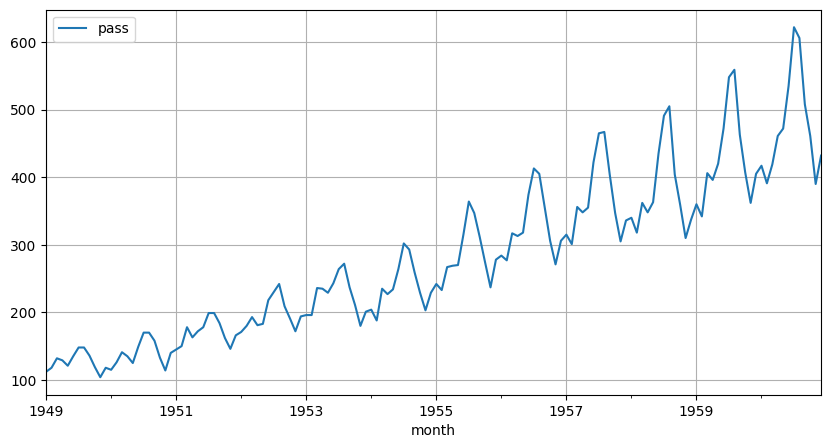

In [297]:
# Plot the data
df.plot(figsize=(10,5))
plt.grid(True)
plt.show()

# Check presence of seasonality - ACF

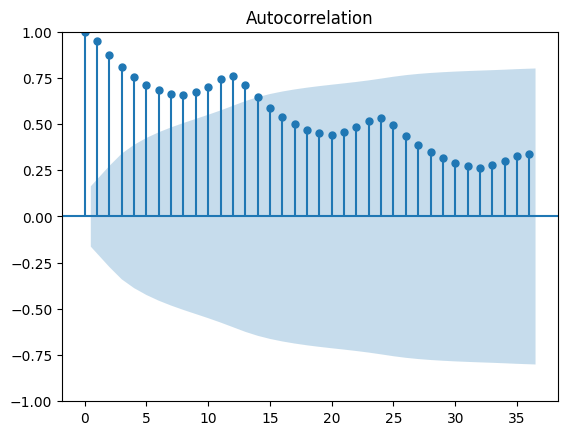

In [298]:
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf

# Assuming 'df_train' is your dataset and 'pass_des' is the column you want to analyze
data = df['pass']
lags = 36

# Plot ACF
plot_acf(data, lags=lags)  # You can adjust the number of lags based on your data
plt.show()

In [299]:
""" # Calculate the ACF values
lags = 36
acf_values = acf(df['pass'], nlags=lags, fft=True)
acf_data = pd.DataFrame({'Lag': range(lags + 1), 'ACF': acf_values})

# Plot the ACF using Plotly
fig = px.bar(acf_data, x='Lag', y='ACF', title='ACF Chart', labels={'ACF': 'Autocorrelation'})
fig.update_layout(
    xaxis=dict(title='Lag'),
    yaxis=dict(title='ACF'),
    template='plotly_white'
)
fig.show() """

" # Calculate the ACF values\nlags = 36\nacf_values = acf(df['pass'], nlags=lags, fft=True)\nacf_data = pd.DataFrame({'Lag': range(lags + 1), 'ACF': acf_values})\n\n# Plot the ACF using Plotly\nfig = px.bar(acf_data, x='Lag', y='ACF', title='ACF Chart', labels={'ACF': 'Autocorrelation'})\nfig.update_layout(\n    xaxis=dict(title='Lag'),\n    yaxis=dict(title='ACF'),\n    template='plotly_white'\n)\nfig.show() "

# Train-test split

In [300]:
df_test = df[-24:].copy()
df_train = df[:-24].copy()

# Check for heterosquedasticity

### Plot residuals after removing the trend

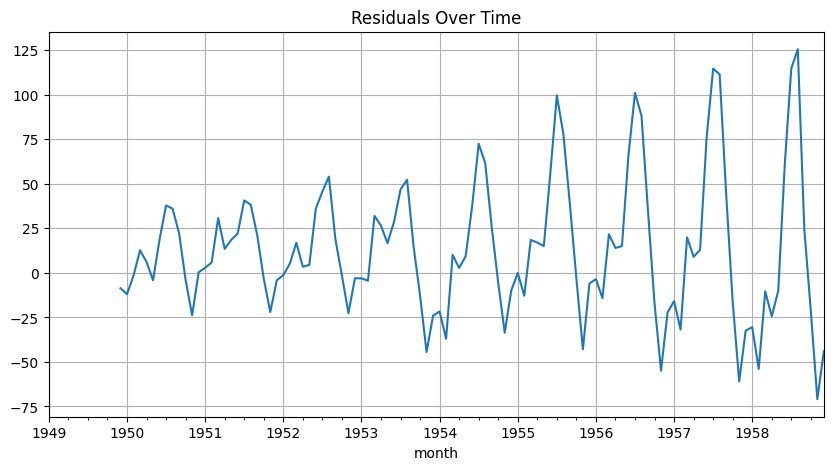

In [301]:
# Compute residuals by removing the trend
df_train['residuals'] = df_train['pass'] - df_train['pass'].rolling(12).mean()  # Approximate trend removal

# Plot residuals
df_train['residuals'].plot(figsize=(10,5))
plt.grid(True)
plt.title("Residuals Over Time")
plt.show()

### Perform Leven's test

In [302]:
# Split data into two halves
first_half = df_train['pass'][:len(df_train)//2]
second_half = df_train['pass'][len(df_train)//2:]

# Perform Levene's test
stat, p_value = levene(first_half, second_half)

# Print results
print(f"Levene’s test statistic: {stat:.4f}, p-value: {p_value:.4f}")

# Interpretation
if p_value < 0.05:
    print("Reject the null hypothesis: Heteroskedasticity detected.")
else:
    print("Fail to reject the null hypothesis: Homoskedasticity not detected.")

Levene’s test statistic: 10.9397, p-value: 0.0012
Reject the null hypothesis: Heteroskedasticity detected.


### Logaritmize data if heterosquedasticity is detected

In [303]:
df_train = df_train.drop(['residuals'], axis=1)
df_train['pass_log'] = np.log(df_train['pass'])
df_train

,pass,pass_log
month,,
1949-01,112,4.718499
1949-02,118,4.770685
1949-03,132,4.882802
1949-04,129,4.859812
1949-05,121,4.795791
...,...,...
1958-08,505,6.224558
1958-09,404,6.001415
1958-10,359,5.883322


# Fit and predict with Theta 

In [304]:
# Define model
model = ThetaModel(df_train['pass_log'],
                   method='additive' # If we logarizmize data we assume additive model
                   )

# fit the model
res=model.fit(
                #use_mle=True
            )

print(res.summary())

                              ThetaModel Results                              
Dep. Variable:               pass_log   No. Observations:                  120
Method:                       OLS/SES   Deseasonalized:                   True
Date:                Tue, 18 Feb 2025   Deseas. Method:               Additive
Time:                        17:58:36   Period:                             12
Sample:                    01-31-1949                                         
                         - 12-31-1958                                         
   Parameter Estimates    
           Parameters     
--------------------------
b0    0.010606896711798852
alpha   0.8820352618875735
--------------------------


In [305]:
# Predict
forecast = res.forecast_components(24,
                                   
                                   )

forecast

,trend,ses,seasonal
1959-01,0.012025,5.91884,-0.084992
1959-02,0.022632,5.91884,-0.105153
1959-03,0.033239,5.91884,0.031983
1959-04,0.043846,5.91884,-0.011725
1959-05,0.054453,5.91884,-0.013677
1959-06,0.065060,5.91884,0.113640
1959-07,0.075667,5.91884,0.200463
1959-08,0.086274,5.91884,0.189328
1959-09,0.096881,5.91884,0.065976
1959-10,0.107488,5.91884,-0.075843


In [306]:
forecast['true'] = df_test['pass']
forecast

,trend,ses,seasonal,true
1959-01,0.012025,5.91884,-0.084992,360
1959-02,0.022632,5.91884,-0.105153,342
1959-03,0.033239,5.91884,0.031983,406
1959-04,0.043846,5.91884,-0.011725,396
1959-05,0.054453,5.91884,-0.013677,420
1959-06,0.065060,5.91884,0.113640,472
1959-07,0.075667,5.91884,0.200463,548
1959-08,0.086274,5.91884,0.189328,559
1959-09,0.096881,5.91884,0.065976,463
1959-10,0.107488,5.91884,-0.075843,407


# Additive model composition and reverse log transformation

In [307]:
# Additive model
forecast['pred'] = forecast['trend']+forecast['ses']+forecast['seasonal']

# Multiplicative model
#forecast['pred'] = forecast['trend'] + alpha * forecast['ses'] * forecast['seasonal']

# Reverse log transformation
forecast['pred'] = np.exp(forecast['pred'])

forecast


,trend,ses,seasonal,true,pred
1959-01,0.012025,5.91884,-0.084992,360,345.804518
1959-02,0.022632,5.91884,-0.105153,342,342.516229
1959-03,0.033239,5.91884,0.031983,406,397.049872
1959-04,0.043846,5.91884,-0.011725,396,384.122201
1959-05,0.054453,5.91884,-0.013677,420,387.461448
1959-06,0.065060,5.91884,0.113640,472,444.762337
1959-07,0.075667,5.91884,0.200463,548,490.276602
1959-08,0.086274,5.91884,0.189328,559,490.017680
1959-09,0.096881,5.91884,0.065976,463,437.771230
1959-10,0.107488,5.91884,-0.075843,407,383.939382


# MAPE and plot

In [308]:
# Calculate MAPE
mape = mean_absolute_percentage_error(forecast['true'],forecast['pred'])
print(f'mape: {mape*100 :.2f}%')

mape: 5.39%


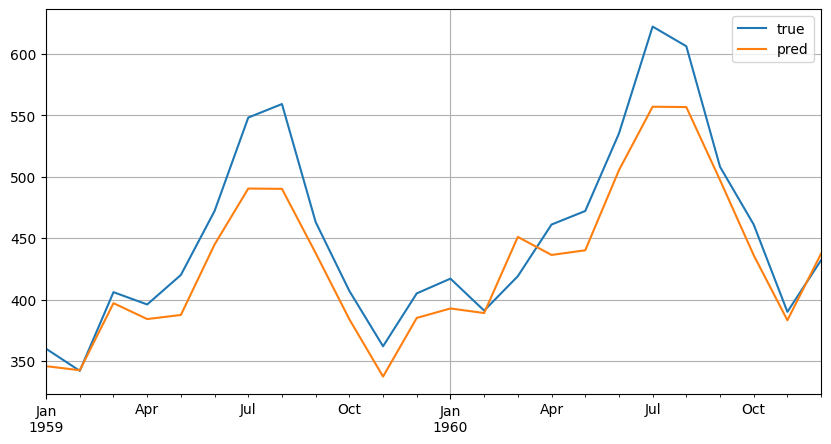

In [309]:
# Plot both columns
forecast[['true', 'pred']].plot(figsize=(10,5))
plt.grid(True)
plt.show()

# Another aproach

### De-seasonalize data

In [310]:
#df_train=df_train.drop(['pass_log'], axis=1)
df_train=df_train.reset_index()
df_train

,month,pass,pass_log
0,1949-01,112,4.718499
1,1949-02,118,4.770685
2,1949-03,132,4.882802
3,1949-04,129,4.859812
4,1949-05,121,4.795791
...,...,...,...
115,1958-08,505,6.224558
116,1958-09,404,6.001415
117,1958-10,359,5.883322
118,1958-11,310,5.736572


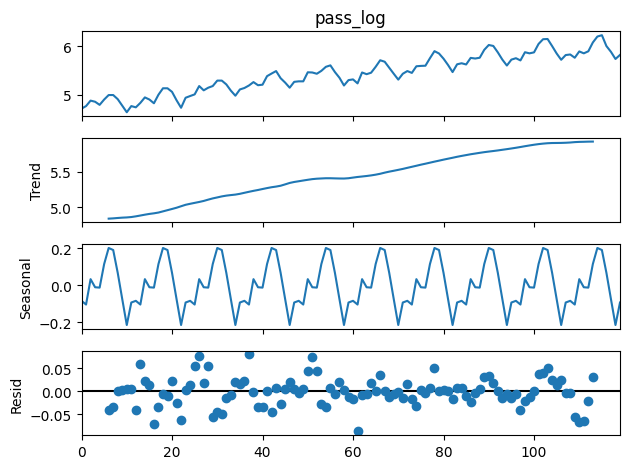

In [311]:
decomposition = seasonal_decompose(df_train['pass_log'], model='additive', period=12)

# Plot the decomposition
decomposition.plot()
plt.show()

In [312]:
df_train['pass_des'] = df_train['pass_log'] - decomposition.seasonal
df_train

,month,pass,pass_log,pass_des
0,1949-01,112,4.718499,4.803491
1,1949-02,118,4.770685,4.875838
2,1949-03,132,4.882802,4.850819
3,1949-04,129,4.859812,4.871538
4,1949-05,121,4.795791,4.809467
...,...,...,...,...
115,1958-08,505,6.224558,6.035231
116,1958-09,404,6.001415,5.935439
117,1958-10,359,5.883322,5.959165
118,1958-11,310,5.736572,5.952386


# OLS find coeficient b0 and b1

In [313]:
y = np.array(df_train['pass_des']).reshape(-1,1)

# Create a predictor
t = np.arange(1, len(y) + 1)  # Time as the predictor
X = sm.add_constant(t)

# Fit the model
theta = sm.OLS(y, X)
model = theta.fit()

# Get params
intercept = model.params[0]
slope = model.params[1]

# Get the coefficients and summary
print(f"Intercept: {intercept:.4f}, Slope: {slope:.4f}")
print(model.summary())

Intercept: 4.7886, Slope: 0.0106
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.980
Model:                            OLS   Adj. R-squared:                  0.980
Method:                 Least Squares   F-statistic:                     5854.
Date:                Tue, 18 Feb 2025   Prob (F-statistic):          2.09e-102
Time:                        17:58:37   Log-Likelihood:                 184.12
No. Observations:                 120   AIC:                            -364.2
Df Residuals:                     118   BIC:                            -358.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          4.78

# SES find coeficient alpha

In [314]:
# SES prediction function
def ses_forecast(y, alpha):
    y_hat = np.zeros_like(y)
    y_hat[0] = y[0]  # Initialize the first prediction as the first value
    for t in range(1, len(y)):
        y_hat[t] = alpha * y[t - 1] + (1 - alpha) * y_hat[t - 1]
    return y_hat

# Objective function to minimize (e.g., Mean Squared Error)
def mse(alpha, y):
    y_hat = ses_forecast(y, alpha)  # Generate predictions
    return np.mean((y - y_hat) ** 2)  # Calculate MSE


In [315]:
# Initial guess for alpha
initial_alpha = 0.5

# Bounds for alpha (0 < alpha < 1)
bounds = [(0, 1)]

# Optimize alpha using MLE (minimize MSE)
result = minimize(mse, x0=initial_alpha, args=(y,), bounds=bounds, method="L-BFGS-B")

# Extract optimized alpha from the result
optimized_alpha = result.x[0]
print(f"Optimized Alpha: {optimized_alpha:.3f}")

Optimized Alpha: 0.882


# Forecast

### Trend

<img src="pics/trend.png" style="width: 40%;"/>

In [316]:
# Inputs for eqation 
b0=slope
alpha=optimized_alpha
theta = 2

# Length of forecasting horizon
fh = len(df_test)

# Array
h = np.arange(1,fh+1)
h

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24])

In [317]:
# Equation of trend 
trend_eqation = (theta-1)*b0 * (h - 1 + (1 / alpha))

# Add trend into test df
df_test['trend'] = trend_eqation
df_test

,pass,trend
month,,
1959-01,360,0.012033
1959-02,342,0.022639
1959-03,406,0.033246
1959-04,396,0.043853
1959-05,420,0.054460
1959-06,472,0.065067
1959-07,548,0.075674
1959-08,559,0.086281
1959-09,463,0.096888


### SES - equation aproach

<img src="pics/ses.png" style="width: 30%;"/>

In [318]:
# SES initialization: first forecast (F1) is simply the first data point
F = np.zeros(len(df_train))  

# Set starting prediction
F[0] = df_train.loc[0, 'pass_des'] 

# Apply SES
for t in range(1, len(df_train)):
    F[t] = alpha * df_train.loc[t-1, 'pass_des'] + (1 - alpha) * F[t-1]

# Pick up the last value
last_item = F[-1]
last_item

# SES forecast
ses_forecast = np.full(fh, last_item)
ses_forecast

# Add to the df
df_test['ses'] = ses_forecast
df_test

,pass,trend,ses
month,,,
1959-01,360,0.012033,5.953014
1959-02,342,0.022639,5.953014
1959-03,406,0.033246,5.953014
1959-04,396,0.043853,5.953014
1959-05,420,0.054460,5.953014
1959-06,472,0.065067,5.953014
1959-07,548,0.075674,5.953014
1959-08,559,0.086281,5.953014
1959-09,463,0.096888,5.953014


### Add seasonal factors (SF) for certain months

In [319]:
SF = forecast['seasonal'].head(fh).to_numpy()

df_test['seasonal'] = SF
df_test

,pass,trend,ses,seasonal
month,,,,
1959-01,360,0.012033,5.953014,-0.084992
1959-02,342,0.022639,5.953014,-0.105153
1959-03,406,0.033246,5.953014,0.031983
1959-04,396,0.043853,5.953014,-0.011725
1959-05,420,0.054460,5.953014,-0.013677
1959-06,472,0.065067,5.953014,0.113640
1959-07,548,0.075674,5.953014,0.200463
1959-08,559,0.086281,5.953014,0.189328
1959-09,463,0.096888,5.953014,0.065976


### Compose ses + trend together for theta factor=2

<img src="pics/ses_trend.png" style="width: 40%;"/>

In [320]:
df_test['pred'] = df_test['ses'] + df_test['trend'] + df_test['seasonal']

df_test['pred_back_log'] = np.exp(df_test['pred'])
df_test

,pass,trend,ses,seasonal,pred,pred_back_log
month,,,,,,
1959-01,360,0.012033,5.953014,-0.084992,5.880055,357.828747
1959-02,342,0.022639,5.953014,-0.105153,5.870500,354.426119
1959-03,406,0.033246,5.953014,0.031983,6.018243,410.855993
1959-04,396,0.043853,5.953014,-0.011725,5.985142,397.478803
1959-05,420,0.054460,5.953014,-0.013677,5.993797,400.934162
1959-06,472,0.065067,5.953014,0.113640,6.131721,460.227503
1959-07,548,0.075674,5.953014,0.200463,6.229151,507.324379
1959-08,559,0.086281,5.953014,0.189328,6.228622,507.056454
1959-09,463,0.096888,5.953014,0.065976,6.115877,452.993304


### MAPE and plot

In [321]:
# Calculate MAPE
mape = mean_absolute_percentage_error(df_test['pass'],df_test['pred_back_log'])
print(f'mape: {mape*100 :.2f}%')

mape: 3.59%


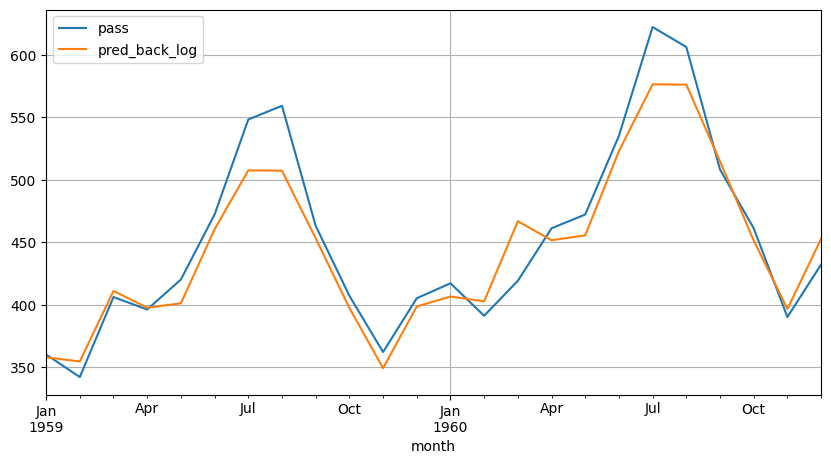

In [322]:
# Plot both columns
df_test[['pass', 'pred_back_log']].plot(figsize=(10,5))
plt.grid(True)
plt.show()